## Step 1. Read data and Check the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

train_data = pd.read_csv('train.csv') 
test_data = pd.read_csv('test.csv') 

# to seperate the target form other column, becuase thry are labels
x_train_label = train_data["y"]
train_data = train_data.drop(columns="y")

all_data = train_data.append(test_data)
all_data = all_data.reset_index(drop=True)

In [2]:
corr_table = pd.concat([train_data, x_train_label], axis = 1).corr()

In [3]:
corr_table = corr_table.loc[:,"y"].dropna()[:-1]

In [4]:
important_corr_table = corr_table.loc[abs(corr_table.values)>0.1]


In [5]:
important_num_col = important_corr_table.index
all_data_num = all_data.loc[:,important_num_col]

In [6]:
category_col = pd.concat([train_data.iloc[:,1:9], x_train_label],axis=1)
category_col = category_col.drop(columns=["X3", "X4", "X8"])

In [7]:
category_col = category_col.drop(columns="X6")

In [8]:
for index, item in enumerate(category_col.X5):
    if item not in ["u", "x", "h", "g", "f"]:
        category_col.X5[index] = "new"


In [9]:
category_col = category_col.drop("y" ,axis=1)

In [10]:
all_data_cate = all_data.iloc[:,1:9]
all_data_cate = all_data_cate.drop(columns=["X3", "X4", "X8"])
all_data_cate = all_data_cate.drop(columns="X6")


In [11]:
for index, item in enumerate(all_data_cate.X5):
    if item not in ["u", "x", "h", "g", "f"]:
        all_data_cate.X5[index] = "new"

In [12]:
# flatten all categorical data using one-hot-encoding
all_data_cate = pd.get_dummies(all_data_cate, drop_first=True ) 

pd.set_option('display.max_columns',200) # to show out at most 200 columns per row
print( "the number of the columns of all data: ", len(all_data_cate.columns) )

the number of the columns of all data:  120


### 2. K-fold Validation with Class_weight

    K-fold to find the best number of epoch  

    Set class_weights, which we get from the previous step (0: 88%, 1:12%), to be {0:0.135, 1:1},  
    so that we can avoid the model tends to predict data as 0, beacuse there are more 0 than 1 in our training set

In [13]:
all_data = pd.concat([all_data_cate, all_data_num], axis=1)

In [14]:
# seperate x_train and x_test from all_data
x_train = all_data[ :len(train_data) ].to_numpy()
x_test = all_data[ len(train_data): ].to_numpy()

x_train_label = x_train_label.to_numpy() # make x_train_label, which is dataframe, to be numpy array

In [15]:
x_train.shape

(4209, 231)

In [83]:
from keras import models, layers, regularizers

def build_model(): # a function to build model
    model = models.Sequential()
    
    model.add(layers.Dense(200, activation="relu", kernel_regularizer = regularizers.l2(0.001), input_shape=(len(x_train[0]),) ) )
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(150, activation="relu", kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(100, activation="relu", kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(50, activation="relu", kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(50, activation="relu", kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(24, activation="relu", kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(1, kernel_regularizer = regularizers.l2(0.001)))

    model.compile(optimizer= "rmsprop", loss= "mse", metrics=["mae"])
    
    return model


### 3. Plot the loss and accuracy of train data and validation data

In [84]:

num_portion = 7
num_val_sameples = len(x_train) // num_portion
num_epochs = 60

all_val_mae = []

for i in range(num_portion): # go through every part of validation
    print("processing fold {} ...".format(i+1))

    val_data = x_train[i*num_val_sameples : (i+1)*num_val_sameples]
    val_label = x_train_label[i*num_val_sameples : (i+1)*num_val_sameples]
    
    prartial_x_train = np.concatenate( [ x_train[: i*num_val_sameples], x_train[(i+1)*num_val_sameples: ] ], axis=0)

    prartial_x_train_label = np.concatenate( [ x_train_label[: i*num_val_sameples],\
                                                x_train_label[(i+1)*num_val_sameples: ] ], axis=0)

    model = build_model()
    #class_weights = {0:0.135, 1:1} # set class_weights, so we can avoid that the model tends to predict data as 0
    """class_weight.compute_class_weight("balanced", np.unique(x_train_label), x_train_label.reshape(-1))"""

    history = model.fit(prartial_x_train, prartial_x_train_label, validation_data=(val_data, val_label),
                        epochs=num_epochs, batch_size=150, verbose=0)
    val_mae = history.history["val_mae"]


    all_val_mae.append(val_mae)
    
    print()

print("< ====== K-fold Validation ends ====== >")

processing fold 1 ...

processing fold 2 ...

processing fold 3 ...

processing fold 4 ...

processing fold 5 ...

processing fold 6 ...

processing fold 7 ...

< ====== K-fold Validation ends ====== >


In [85]:
average_all_mae = [ np.mean( [ x[i] for x in all_val_mae] ) for i in range(num_epochs) ]

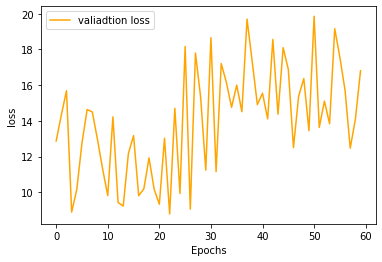

In [86]:
plt.plot(range(len(average_all_mae)), average_all_mae, 'b', color='orange', label = "valiadtion loss")

plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

### 1. Use the best epoch got from K-fold Validation to build the model to predict test data

In [89]:
final_model = build_model()

final_model.fit(x_train, x_train_label, epochs=2, batch_size=150, verbose=0,)

answer = final_model.predict(x_test)
answer = pd.DataFrame(data=answer, columns=["y"])

In [90]:
answer = pd.DataFrame(data=answer, columns=["y"])

## Step 6. Output the outcome to csv

In [91]:
output = pd.read_csv('test.csv', usecols = ["ID"]) 
output = pd.concat([output, answer], axis=1)
output.to_csv("submit_now.csv", index=0)

In [92]:
output

,ID,y
0,2,84.820404
1,8,96.428764
2,12,90.342186
3,14,92.248367
4,15,84.963821
...,...,...
995,4192,94.068855
996,4193,100.669327
997,4197,85.496429
998,4201,97.084831
